# (15.0) Описание решаемой задачи

Обновление ордерлога данными по найденным айсбергам и расчет метрик ликвидности на основании новых данных

# (15.1) Установка необходимых пакетов

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (15.2) Определение функций

In [2]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# (15.3) Список всех использующихся датафреймов¶¶

In [3]:
# orders - ордерлог на заданную дату
# iceberg_all - список всех найденных айсбергов
# orders_instr - ордерлог по инструменту
# ice_instr_day - список айсбергов по одному инструменту за один день
# chain_results - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены
# chain_results_instr_day - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены по инструменту
# all_day_chain - список всех цепочек с указанием их метрик
# all_day_chain_instr_day - список всех цепочек с указанием их метрик по инструменту

# (15.4) Определение входных параметров

In [6]:
# создаем список из инструментов, относящихся к числу голубых фишек
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [7]:
# создаем список из всех названий файлов с данными
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [9]:
ticker = tickers[14] #ALRS
orderlog = orderlogs[0]
date = orderlog[8:16] #20190304

# (15.5) Чтение данных

In [10]:
# читаем ордерлог
# orders - ордерлог на заданную дату
orders = pd.read_csv(orderlog, header = 0)
orders['together_time'] = str(date)+orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']

In [11]:
# отбираем данные по инструменту
# orders_instr - ордерлог по инструменту
orders_instr = orders[orders.SECCODE == ticker]

In [12]:
# читаем файл с выявленными айсбергами
# iceberg_all - список всех айсбергов с указанием цепочки
iceberg_all = pd.read_csv('iceberg.csv', header = 0)
del iceberg_all['index']
iceberg_all.reset_index(level=0, inplace=True)
iceberg_all.rename(columns = {'index':'ID'}, inplace=True)

In [13]:
# отбираем данные по инструменту
# ice_instr_day - список айсбергов по одному инструменту за один день
ice_instr_day = iceberg_all[(iceberg_all.SECCODE == ticker)&(iceberg_all.DATE == int(date))]

In [14]:
# читаем данные по цепочкам
# chain_results - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены
chain_results = pd.read_csv('chain_results.csv', header = 0)
# chain_results_instr_day - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены по инструменту
chain_results_instr_day = chain_results[(chain_results.TICKER == ticker)&(chain_results.DATE == int(date))].reset_index()
# читаем данные по основным характеристикам цепочек
# all_day_chain - список всех цепочек с указанием их метрик
all_day_chain = pd.read_csv('all_day_chain.csv', header = 0)
# all_day_chain_instr_day - список всех цепочек с указанием их метрик по инструменту
all_day_chain_instr_day = all_day_chain[(all_day_chain.TICKER == ticker)&(chain_results.DATE == int(date))].reset_index()

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
%%time
# определяем ордерно всех заявок из цепочки
# находим эти заявки в orders_instr
# обновляем первоначальный объем первой заявки в цепочке
# удалить запись о выставлении всех остальных заявок в цепочке
# обновляем ордерно в указании об исполнении всех других заявок в цепочке на ордерно первой заявки в цепочке
for a in range(len(all_day_chain_instr_day)):
    
    chain_id = all_day_chain_instr_day.loc[a, 'CHAIN_ID']
    orders_in_chain = chain_results_instr_day[chain_results_instr_day.CHAIN_ID == chain_id]['ORDERNO'].to_list()
    first_order_in_chain = orders_in_chain[0]
    # ищем первый элемент цепочки и обновляем объем на величину общего объема цепочки
    index_in_all_day = all_day_chain_instr_day.index[all_day_chain_instr_day.CHAIN_ID == chain_id].to_list()[0]
    chain_volume = all_day_chain_instr_day.loc[index_in_all_day, 'VOLUME']
    orders_instr.loc[(orders_instr['ORDERNO'] == first_order_in_chain) & (orders_instr['ACTION'] == 1),'VOLUME'] = chain_volume
        
    # если длина цепочки больше единицы, то 1) удаляем все записи о выставлении последующих элементов цепочки
    # 2) меняем ордерно об исполнении или отмене последующих элементов цепочки на ордерно первого элемента цепочки
    if len(orders_in_chain) != 1:
        
        # исключаем из цепочки первый элемент
        rest_orders_in_chain = orders_in_chain[1:len(orders_in_chain)]
        # удаляем записи о выставлении последующих элементов цепочки
        orders_instr = orders_instr.drop(orders_instr[(orders_instr['ORDERNO'].isin(rest_orders_in_chain)) & (orders_instr['ACTION']==1)].index)
        # меняем ордерно об исполнении или отмене последующих элементов цепочки на ордерно первого элемента
        orders_instr.loc[(orders_instr['ORDERNO'].isin(rest_orders_in_chain)) & (orders['ACTION']!=1),'ORDERNO'] = first_order_in_chain

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 9min 15s, sys: 31.1 s, total: 9min 46s
Wall time: 9min 29s


In [16]:
%%time 
# считаем метрики ликвидности на основании исходных данных и записываем их в датафрейм
# рассчитываем метрики ликвидности на основании восстановленного стакана на каждые пять минут
# liquidity - метрики ликвидности на каждые 5 минут по одному инструменту за один день
# определяем начальный момент времени
liquidity = []
time = ReverseToDateTime('20190304'+'100500000000')
orders_instr_prev = orders[orders.SECCODE == ticker]

while time <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
    instrtime_orders = orders_instr_prev[(orders_instr_prev.TIME <= time)]
    liquidity.append([time, GlassBuild(instrtime_orders)])
    time = time + dt.timedelta(minutes=5)
    
liquidity = pd.DataFrame(liquidity)
liquidity['BID_PRICE'] = [liquidity[1][i][0] for i in range(len(liquidity[1]))]
liquidity['BID_VOLUME'] = [liquidity[1][i][1] for i in range(len(liquidity[1]))]
liquidity['BID_DEPTH'] = [liquidity[1][i][2] for i in range(len(liquidity[1]))]
liquidity['BID_10_DEPTH'] = [liquidity[1][i][3] for i in range(len(liquidity[1]))]
liquidity['ASK_PRICE'] = [liquidity[1][i][4] for i in range(len(liquidity[1]))]
liquidity['ASK_VOLUME'] = [liquidity[1][i][5] for i in range(len(liquidity[1]))]
liquidity['ASK_DEPTH'] = [liquidity[1][i][6] for i in range(len(liquidity[1]))]
liquidity['ASK_10_DEPTH'] = [liquidity[1][i][7] for i in range(len(liquidity[1]))]

liquidity = liquidity.rename(columns = {0:'TIME'})

del liquidity[1]

CPU times: user 15.3 s, sys: 2.05 s, total: 17.3 s
Wall time: 15.5 s


In [17]:
%%time 
# считаем метрики ликвидности на основании обновленных данных и записываем их датафрейм
# рассчитываем метрики ликвидности на основании восстановленного стакана на каждые пять минут
# liquidity - метрики ликвидности на каждые 5 минут по одному инструменту за один день
# определяем начальный момент времени
liquidity1 = []
time = ReverseToDateTime('20190304'+'100500000000')

while time <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
    instrtime_orders = orders_instr[(orders_instr.TIME <= time)]
    liquidity1.append([time, GlassBuild(instrtime_orders)])
    time = time + dt.timedelta(minutes=5)

liquidity1 = pd.DataFrame(liquidity1)
liquidity1['BID_PRICE_ICE'] = [liquidity1[1][i][0] for i in range(len(liquidity1[1]))]
liquidity1['BID_VOLUME_ICE'] = [liquidity1[1][i][1] for i in range(len(liquidity1[1]))]
liquidity1['BID_DEPTH_ICE'] = [liquidity1[1][i][2] for i in range(len(liquidity1[1]))]
liquidity1['BID_10_DEPTH_ICE'] = [liquidity1[1][i][3] for i in range(len(liquidity1[1]))]
liquidity1['ASK_PRICE_ICE'] = [liquidity1[1][i][4] for i in range(len(liquidity1[1]))]
liquidity1['ASK_VOLUME_ICE'] = [liquidity1[1][i][5] for i in range(len(liquidity1[1]))]
liquidity1['ASK_DEPTH_ICE'] = [liquidity1[1][i][6] for i in range(len(liquidity1[1]))]
liquidity1['ASK_10_DEPTH_ICE'] = [liquidity1[1][i][7] for i in range(len(liquidity1[1]))]

liquidity1 = liquidity1.rename(columns = {0:'TIME'})

del liquidity1[1]

CPU times: user 14.9 s, sys: 2.06 s, total: 17 s
Wall time: 16.1 s


In [18]:
# сливаем метрики ликвидности в один датафрейм
liquidity = liquidity.merge(liquidity1, on = 'TIME', how='outer')
liquidity

,TIME,BID_PRICE,BID_VOLUME,BID_DEPTH,BID_10_DEPTH,ASK_PRICE,ASK_VOLUME,ASK_DEPTH,ASK_10_DEPTH,BID_PRICE_ICE,BID_VOLUME_ICE,BID_DEPTH_ICE,BID_10_DEPTH_ICE,ASK_PRICE_ICE,ASK_VOLUME_ICE,ASK_DEPTH_ICE,ASK_10_DEPTH_ICE
0,2019-03-04 10:05:00,94.98,430.0,385530.0,23560.0,95.08,410.0,915830.0,29800.0,94.98,430.0,385530.0,23560.0,95.08,410.0,915830.0,29800.0
1,2019-03-04 10:10:00,95.00,1200.0,455070.0,44610.0,95.05,550.0,930790.0,18040.0,95.00,1200.0,462730.0,44610.0,95.05,550.0,930790.0,18040.0
2,2019-03-04 10:15:00,95.12,400.0,515560.0,37880.0,95.15,60.0,986560.0,24550.0,95.12,400.0,523220.0,37880.0,95.15,60.0,986560.0,24550.0
3,2019-03-04 10:20:00,95.15,3260.0,588430.0,14850.0,95.21,580.0,1002250.0,29710.0,95.15,3260.0,596090.0,14850.0,95.21,580.0,1002250.0,29710.0
4,2019-03-04 10:25:00,95.29,750.0,603970.0,16260.0,95.30,3000.0,1011270.0,32630.0,95.29,750.0,611630.0,16260.0,95.30,3000.0,1011270.0,32630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2019-03-04 18:25:00,93.60,4420.0,1395000.0,34170.0,93.62,26970.0,2005300.0,61620.0,93.60,4420.0,1434860.0,74030.0,93.62,26970.0,2005300.0,61620.0
101,2019-03-04 18:30:00,93.63,3460.0,1422220.0,47530.0,93.64,23290.0,2024800.0,57040.0,93.63,3460.0,1462080.0,47530.0,93.64,23290.0,2024800.0,57040.0
102,2019-03-04 18:35:00,93.60,1050.0,1407250.0,27420.0,93.61,4580.0,1996490.0,30450.0,93.60,1050.0,1447110.0,27420.0,93.61,4580.0,1996490.0,30450.0
103,2019-03-04 18:40:00,93.67,400.0,1580360.0,37890.0,93.70,1280.0,2208570.0,38020.0,93.67,400.0,1620220.0,37890.0,93.70,1280.0,2208570.0,38020.0


In [21]:
liquidity['BID_DELTA'] = np.where(liquidity['BID_10_DEPTH_ICE'] > liquidity['BID_10_DEPTH'], liquidity['BID_10_DEPTH_ICE'],float('nan'))
liquidity['ASK_DELTA'] = np.where(liquidity['ASK_10_DEPTH_ICE'] > liquidity['ASK_10_DEPTH'], liquidity['ASK_10_DEPTH_ICE'],float('nan'))

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


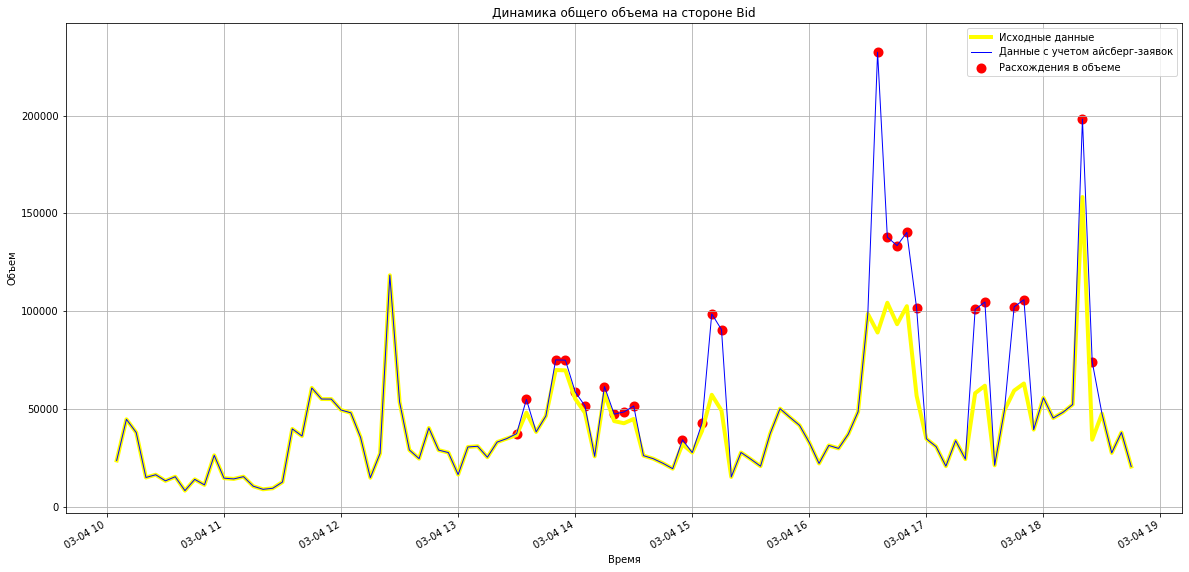

In [24]:
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика общего объема на стороне Bid')
plt.xlabel('Время')
plt.ylabel('Объем')
ax.plot(liquidity.TIME, liquidity.BID_10_DEPTH, linestyle = '-', linewidth = 4, color = 'yellow', label = 'Исходные данные')
ax.plot(liquidity.TIME, liquidity.BID_10_DEPTH_ICE, linestyle = '-', linewidth = 1, color = 'blue', label = 'Данные с учетом айсберг-заявок')
ax.scatter(liquidity.TIME, liquidity.BID_DELTA, linestyle = '-', linewidth = 4, color = 'red', label = 'Расхождения в объеме')
ax.legend()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.gcf().autofmt_xdate()
plt.show()